



## Introduction

This notebook threats the problem of identifying patterns of behavior in networks and services, we present the Dirichlet process categorical mixture model. We suppose that all the data has been transformed into discrete categorical data. We apply the model to data gathered from GPON-FTTH network, and...

## Notations and data
### Random variables:
* We denote random variables as $X_1, X_2, ..., X_d$ where $X_i$ is the ith random variable (Power or alarm, ..). 
* We denote by $Val(X_i)$ as the set of discrete values taken by $X_i$.
* We denote $x_{ni}$ the nth instance of variable $X_i$ in the dataset.
* $\mathcal{D} = (x_{ni})_{n,i}$ : The complete dataset
* We denote by $z_n$ The hidden class variable for instance n.


## Description of the DPCMM

### Model
<div class="pull-right">
<img src="platenotation.png", width="200",alt="">
</div>

\begin{equation*}
    \begin{aligned}
        \beta_k & \sim Beta(1, \eta) \\
        \pi_k  & = \beta_k \prod_{l=1}^{k-1} (1- \beta_l) \\
        z_n & \sim  cat(.|\pi) = \prod_{k=1}^\infty \pi_k ^{\mathbb{1}[z_n=k]} \\
        b_{ki} & \sim Dir(.| \alpha_i, |X_i|) = \prod_{v \in Val(X_i)}b_{v,k,i} ^{\alpha_{iv} - 1} \quad s.t \quad \sum_{v \in Val(X_i)} b_{v,k,i} = 1 \\ 
        x_{ni}|z_n=k, b & \sim cat(.| b_{ki}) = \prod_{v \in Val(X_i)}b_{v,k,i} ^{\mathbb{1}[x_{ni}=v]} 
\end{aligned}
\end{equation*}


### Inference on the model:
The inference in the DPCMM is done by computing the posterior distribution: 

$$ p(\beta, z, b | \mathcal{D}) = \frac{p(\beta, z, b, \mathcal{D})}{p(\mathcal{D})} $$
We can drop the constant term $ p(\mathcal{D}) $ and the objectif is to compute or estimate $p(\beta, z, b, \mathcal{D})$ We have:

$$ p(\beta, z, b, \mathcal{D}) = \prod_{i=1}^d \prod_{n=1}^N p(x_{ni}|z_n, b_{z_n, i})p(z_n|\beta) \prod_{k=1}^\infty p(b_{k,i})  p(\beta_k) $$

Computing this quantity in close forme is not possible, the prior is a product of infinite terms and infinite parameters. One approach is to preform MCMC methods such as Gibbs sampling, where the Markov chain converges to the posterior of interest. The evaluation of convergence of these methods is hard and scalability is a problem also. In the following section we introduce the approach of variational inference this approach tries to approximate the posterior of interest using a family of simpler and tractable distributions. The problem is thus to find the best member of the family that is closest (in terms of kullback leibler divergence) to the posterior of interest. Thus transforming the problem of inference into an optimization problem where we can use all the mathematical background in this field to solve the inference problem. 

### Mean Field variational inference [Murphy, Blei, ...]:

The main idea is to approximate $$ p(\beta, z, b, \mathcal{D}) $$ using simpler family of distribution, the mean field approach tracks back to physics and probablity theory (https://en.wikipedia.org/wiki/Mean_field_theory) For our case the 

mean field family can be written as:
$$ q(z,b,\beta) = \prod_{k=1}^K \prod_{i=1}^d q(b_{k,i}) q(\beta_k) \prod_{n=1}^N q(z_n) $$
We suppose that the approximating distribution is a simple factored distribution, the infinite parameters are truncated into a level K so the product becomes finite.

And the objective is to solve the following optimization problem:
$$ \min_q \mathbb{D}_{KL} [q || p]$$

The mean field theorem states that the solution to this equation $q^{*}$ for the set of parameters $\zeta = \{z, \beta, b \}$ verifies: 


$$ \log q_{j}^{*}(\zeta_j) = const + \mathbb{E}_{\zeta \setminus \{\theta_j \} \sim q^{*}} [\log p(\zeta , \mathcal{D})]$$

In order to compute the approximating distribution, we need to compute the expectancies, which for exponential family distributions is tractable.

### Application to DPCMM:

For the model considered computing the expectancies leads to the following approximating distributions:

* #### Computing $q^{*}$:

$$ q^{*}_n(z_n) = cat(. | \phi_n) $$

$$ q^{*}_{k,i}(b_{k,i}) = Dir(. | \epsilon_{k,i}, |X_i| ) $$

$$ q^{*}_{k}(\beta_{k}) = Beta(. | \gamma_{k,1}, \gamma_{k,2} ) $$

where

$$ \log \phi_{nk} = \sum_{i=1}^d \sum_{v \in Val(X_i)} (\alpha_i + \mathbb{1}[x_{ni}=v] - 1) \{ \psi(\epsilon_{v,k,i} ) - \psi(\sum_v \epsilon_{v,k,i} ) \} +  \psi( \gamma_{k,1} ) - \psi( \gamma_{k,1} +  \gamma_{k,2} ) + \sum_{l=1}^{k-1} \{\psi( \gamma_{l,2} ) - \psi( \gamma_{l,1} +  \gamma_{l,2} )\} $$

$$ \gamma_{k,1} = 1 + \sum_{n=1}^N \phi_{nk} $$

$$ \gamma_{k,2} = \eta + \sum_{n=1}^N \sum_{l=k+1}^K \phi_{nl} $$

$$ \epsilon_{v, k, i} = \alpha_{v,i} + \sum_{n=1}^N \phi_{nk} \mathbb{1}[x_{ni}=v] $$

$ \psi $ : is the digamma function derivative of log gamma.

The following update rules lead to an iterative algorithm similar to EM where the E step is the update of $\phi$ ($z_n$ local parameters) and M step is the update of $b$ and $\beta$ the global parameters.

The variational inference approach has two advantages:
* The update equations can be coded in matrix form, so the approach is scalable can draw from highly optimized packages such as numpy.
* The convergence to the true distribution can be monitored using the log predictive probability defined as:

$$ \mathcal{L} = \mathbb{E}_{\theta \sim q^{*} } [\log p(\theta , \mathcal{D}) ]$$

### Experiments on GPON-FTTH data:



In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from utils import cluster_acc
from model import *

pd.options.display.max_rows = 4000
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(16,12)})

filename = "BN_data.csv"
cluster_dim = "label"


In [18]:
data = pd.read_csv(filename, sep='\t', engine='python').astype(str)

# Clustering the data using the IMCMM
X = data.drop(cluster_dim, axis=1) # Droping the labels
y_true = pd.Categorical(data[cluster_dim])
K_true = y.unique().shape[0]

truncation_level = 50
L = []
y_pred = 0
n_runs = 15
accuracies = [0]*n_runs
for t in range(n_runs):
    model = InfiniteCategoricalMixtureModel(X, concentration_parameter=0.001, K=truncation_level, coef=10)
    L_t = model.gradient_ascent(max_iter=1000,debug=False)
    y_pred_t = model.infer_clusters()
    accuracies[t] =  cluster_acc(y_pred_t, y_true.codes)
    L.append(L_t)

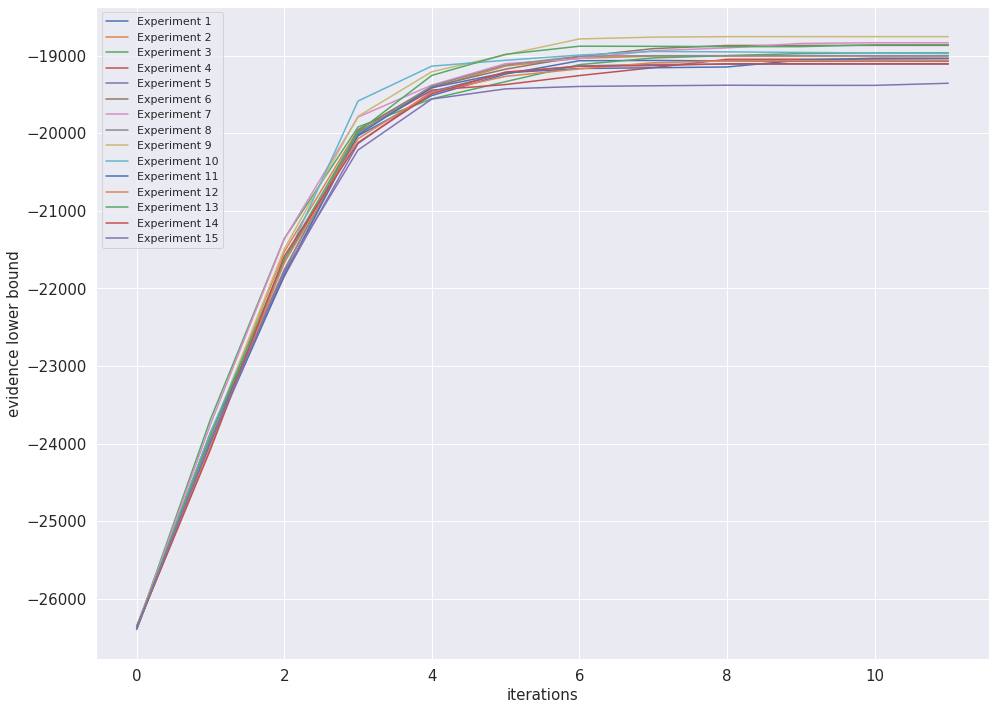

In [19]:
# Ploting the evidence lower bound for each  run of the algorithm
for i in range(n_runs):
    plt.plot(range(len(L[i]))[:12], L[i][:12], label="Experiment " + str(i + 1))
plt.xlabel('iterations', fontsize=15)
plt.ylabel('evidence lower bound', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.savefig("VLB.pdf",bbox_inches="tight")

In [20]:
# Identifying the best model from the elbo :

highest_l = -np.inf
for i in range(n_runs):
    if highest_l < L[i][-1]:
        highest_l = L[i][-1]
        index = i

print("Best model clustering accuracy : ", accuracies[index][0])

Best model clustering accuracy :  0.9677777777777777


In [21]:
acc = accuracies[index]
df = pd.DataFrame(acc[1])
df = df.loc[:, (df != 0).any(axis=0)]
D_c = {}
for i in range(len(y.categories)):
    D_c[i] = y.categories[i]
D_r = {}   
for i in range(50):
    D_r[i] = "cluster "+str(i)
df = df.rename(columns = D_c, index=D_r)
# print("Confusion matrix : ")
df

AltOLT  AltONT  FaultyONT  FiberDB  IOS  TcOLT
cluster 0        0       0          0        0    0      0
cluster 1        0      17          2        0    3    145
cluster 2        0       0          0        0    0      0
cluster 3        0       0          0        0    0      0
cluster 4        0       0          1      150    0      2
cluster 5        0       1          0        0  147      3
cluster 6        0     132          0        0    0      0
cluster 7        0       0        147        0    0      0
cluster 8        0       0          0        0    0      0
cluster 9        0       0          0        0    0      0
cluster 10       0       0          0        0    0      0
cluster 11       0       0          0        0    0      0
cluster 12       0       0          0        0    0      0
cluster 13     150       0          0        0    0      0

In [10]:
filename = "/home/mlws/Desktop/data/diag_data.csv"

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
data = pd.read_csv(filename, sep=',', engine='python').astype(str)
#y = pd.Categorical(data[cluster_dim])
#K = y.unique().shape[0]
T = 50
print(K)
#X = data.drop(cluster_dim, axis=1)

model = InfiniteCategoricalMixtureModel(data, concentration_parameter=0.001, K=T)
L = model.gradient_ascent(max_iter=1000,debug=False)
y_pred = model.infer_clusters()
result_df = data
result_df['cluster'] = y_pred
result_df.head()

6


voip_status olt_status ont_status ont_download_status router_ipv6_status  \
0     VOIP_KO         OK    Missing             Missing            ENABLED   
1     VOIP_OK         OK   NODEFECT             PLANNED            ENABLED   
2     VOIP_OK         OK    Missing             Missing            ENABLED   
3     VOIP_KO         OK   NODEFECT             PLANNED            ENABLED   
4     VOIP_OK         OK   NODEFECT             PLANNED            Missing   

  router_line_status router_status router_sfp_status router_pnp_status  \
0                 UP       ENABLED           Missing              TRUE   
1                 UP       ENABLED           Missing              TRUE   
2                 UP       ENABLED                OK              TRUE   
3                 UP       ENABLED           Missing              TRUE   
4            Missing       Missing           Missing              TRUE   

  router_WiFiCommSecured_status  ... router_WiFi_status  \
0                   DEACTIVATED  ...                 UP   
1                   DEACTIVATED  ...               DOWN   
2                   DEACTIVATED  ...                 UP   
3                   DEACTIVATED  ...                 UP   
4                       Missing  ...            Missing   

  router_plug&play_status RemotePVR_status SVOD_ftth_status  \
0                 Missing          Missing      OPERATIONAL   
1                 Missing      OPERATIONAL      OPERATIONAL   
2           EUA_CERTIFIED      OPERATIONAL      OPERATIONAL   
3                 Missing          Missing      OPERATIONAL   
4                 Missing      OPERATIONAL      OPERATIONAL   

  TVconf_ftth_status tv_profile_status   rfs_status client_account_status  \
0        OPERATIONAL       OPERATIONAL  OPERATIONAL                   1.0   
1        OPERATIONAL       OPERATIONAL  OPERATIONAL                   1.0   
2        OPERATIONAL       OPERATIONAL  OPERATIONAL                   1.0   
3        OPERATIONAL       OPERATIONAL  OPERATIONAL                   1.0   
4        OPERATIONAL       OPERATIONAL  OPERATIONAL                   1.0   

  uhd_device_status cluster  
0           Missing       4  
1           Missing       0  
2                UP      28  
3           Missing      23  
4           Missing       3  

[5 rows x 22 columns]

In [22]:
filename = "/home/mlws/Desktop/data/diag_data.csv"
import pandas as pd
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
data = pd.read_csv(filename, sep=',', engine='python').astype(str)

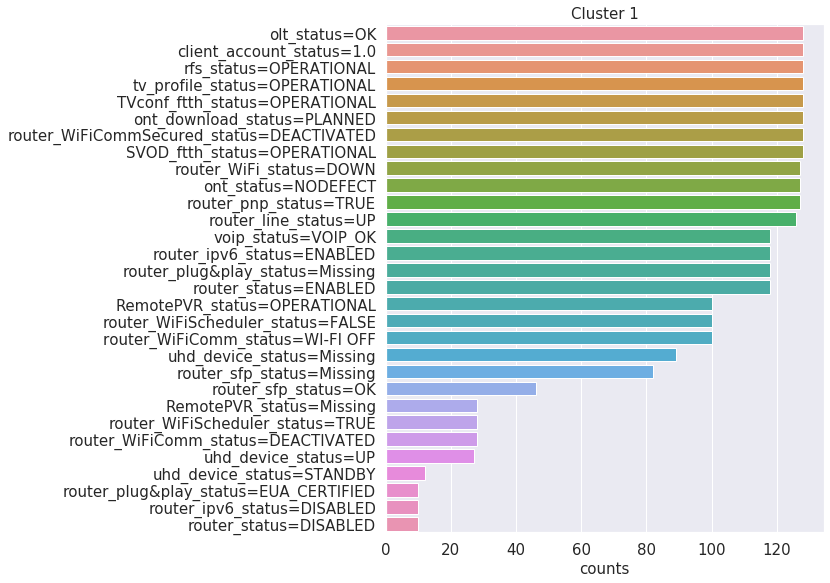

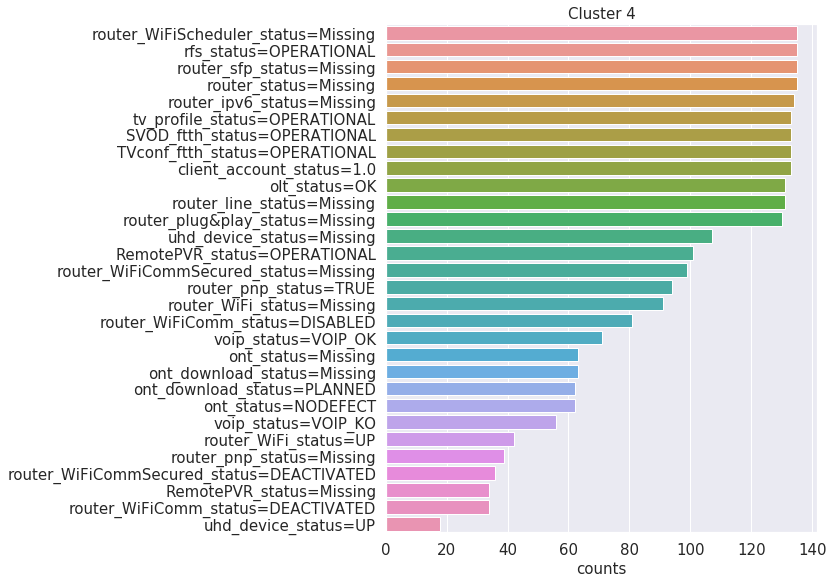

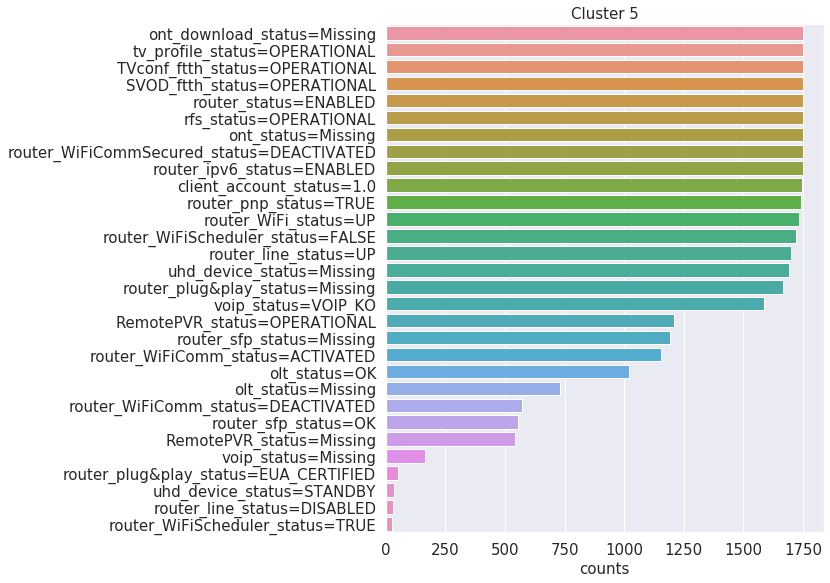

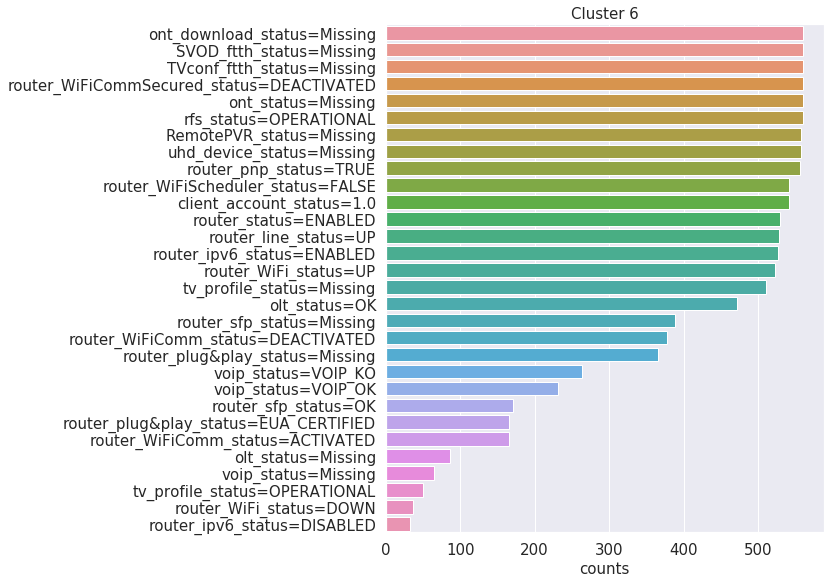

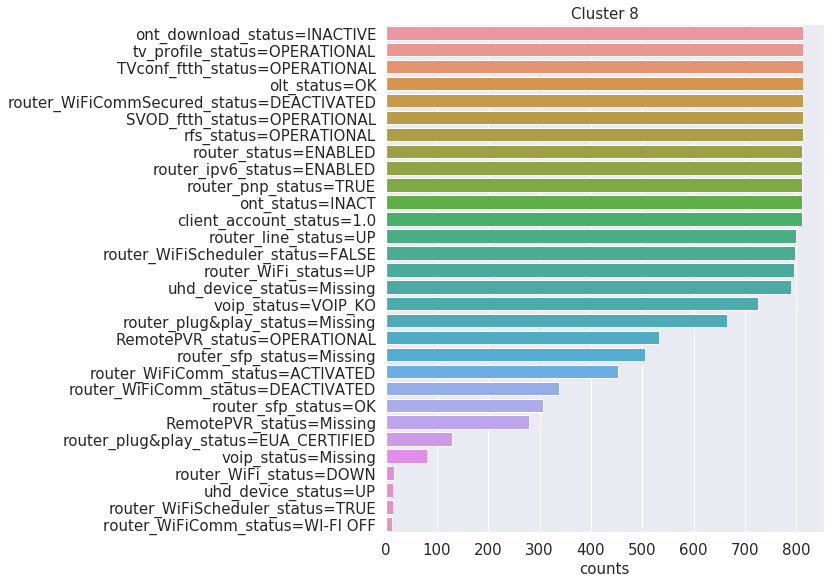

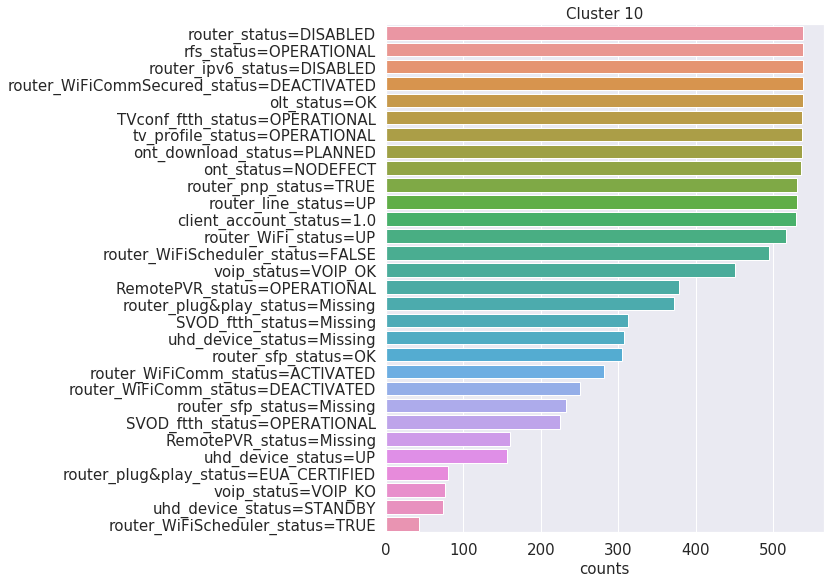

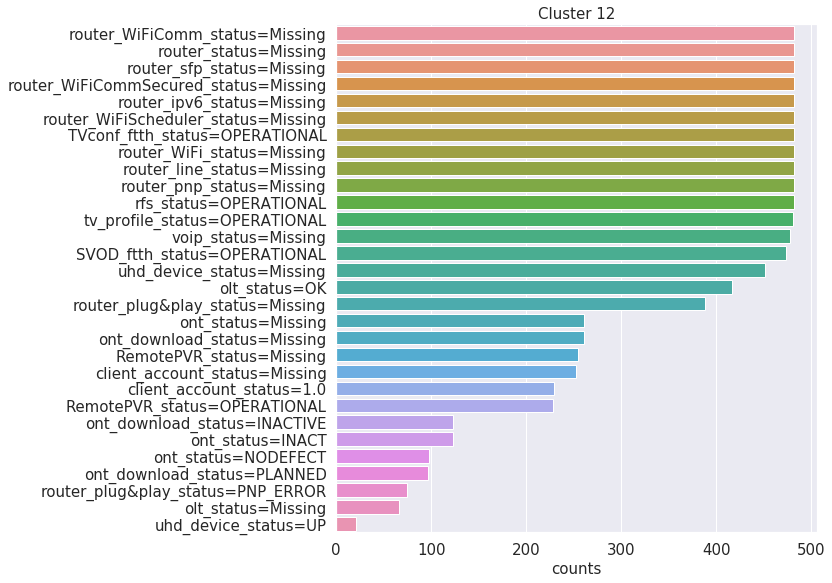

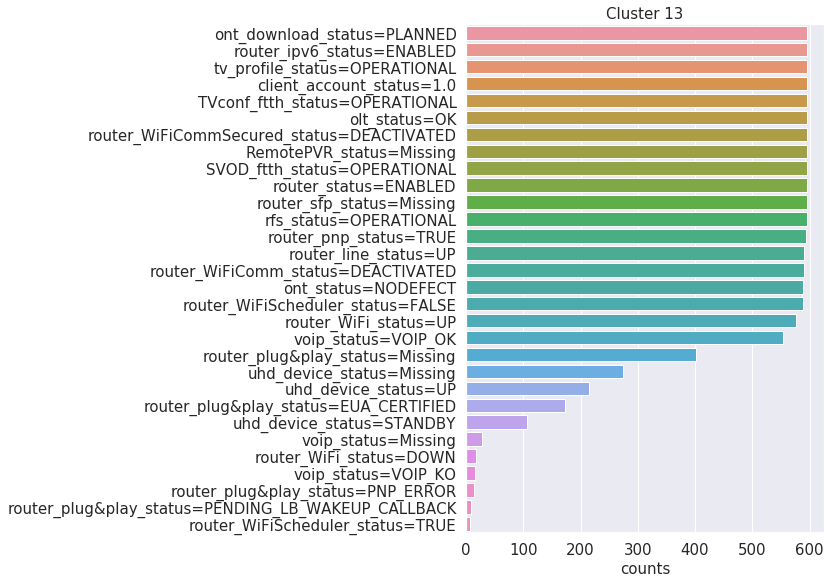

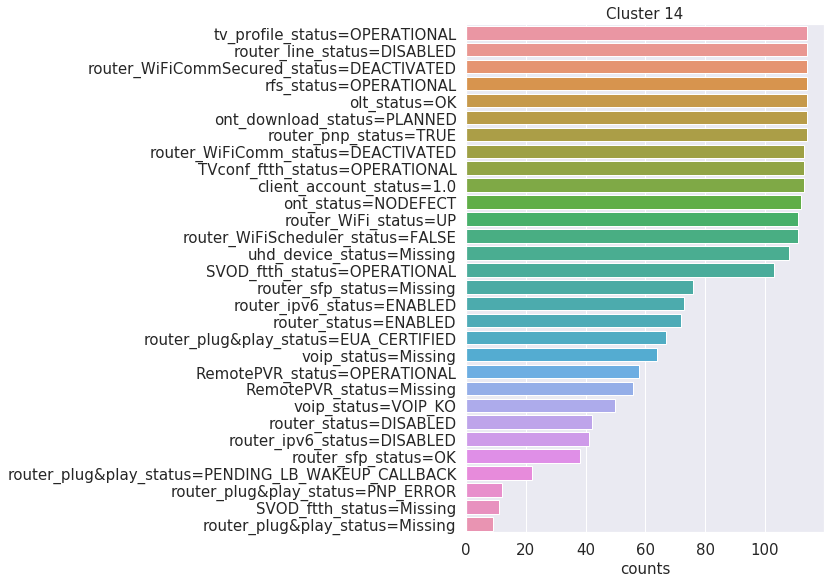

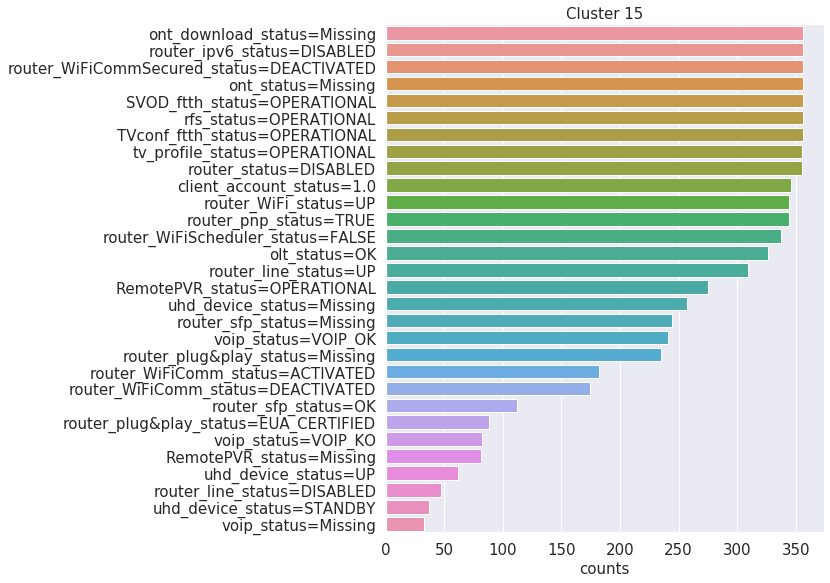

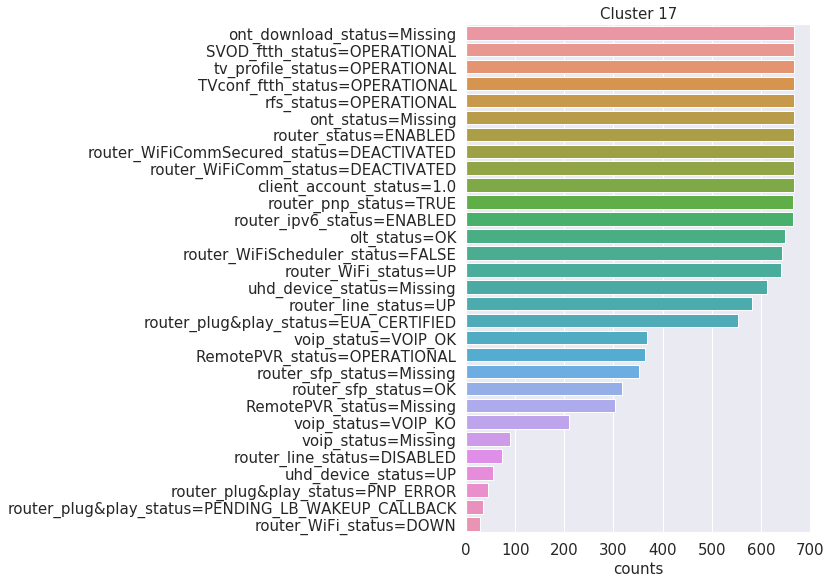

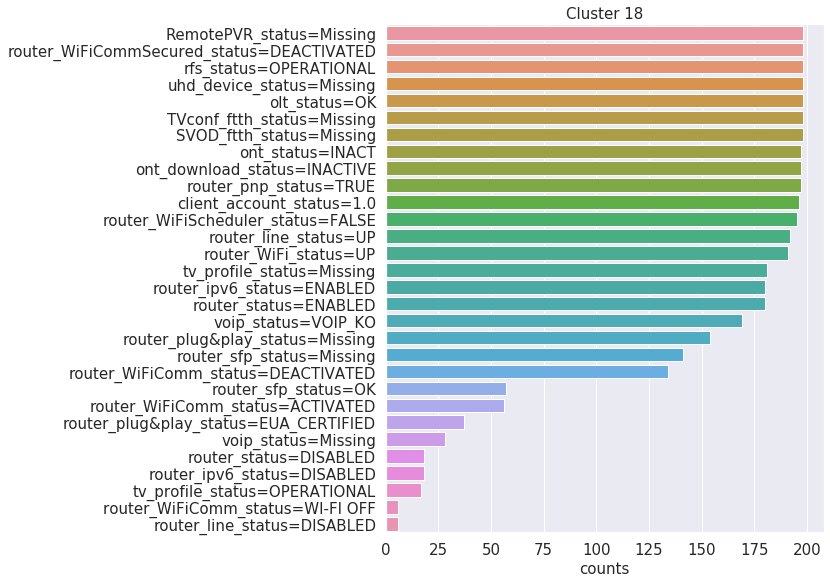

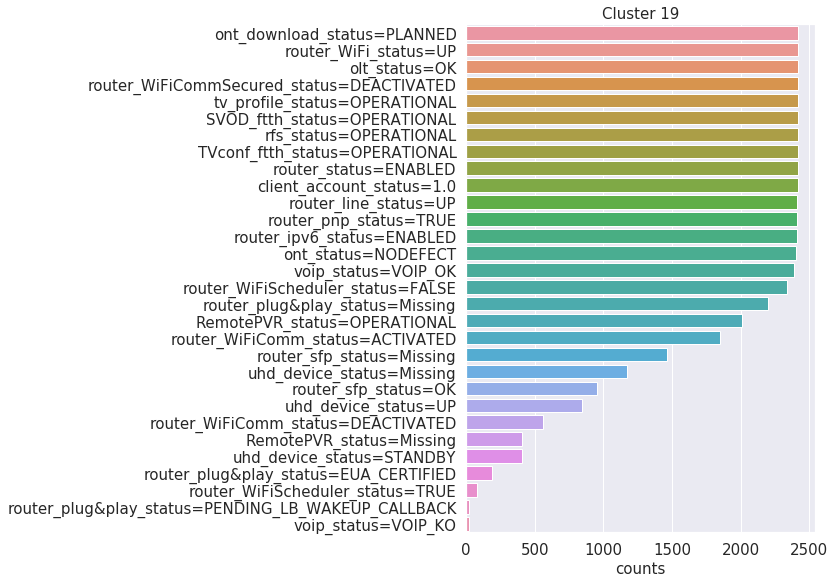

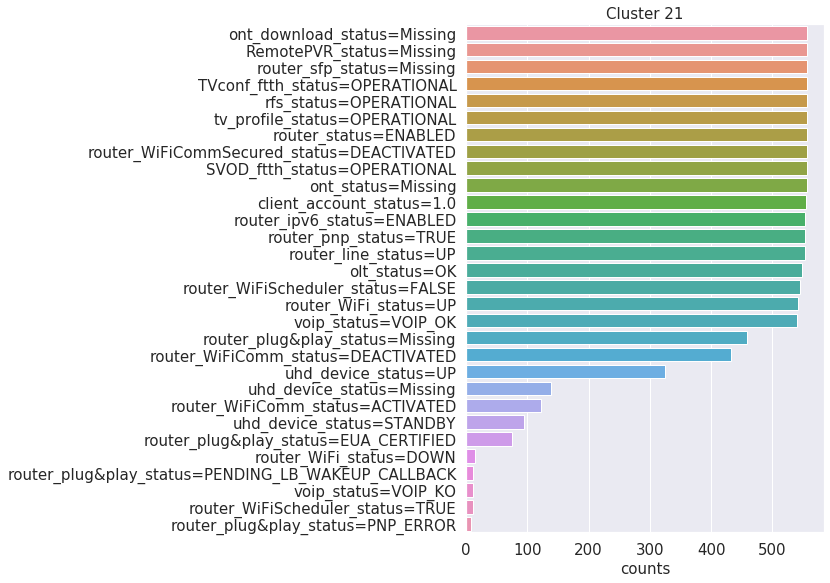

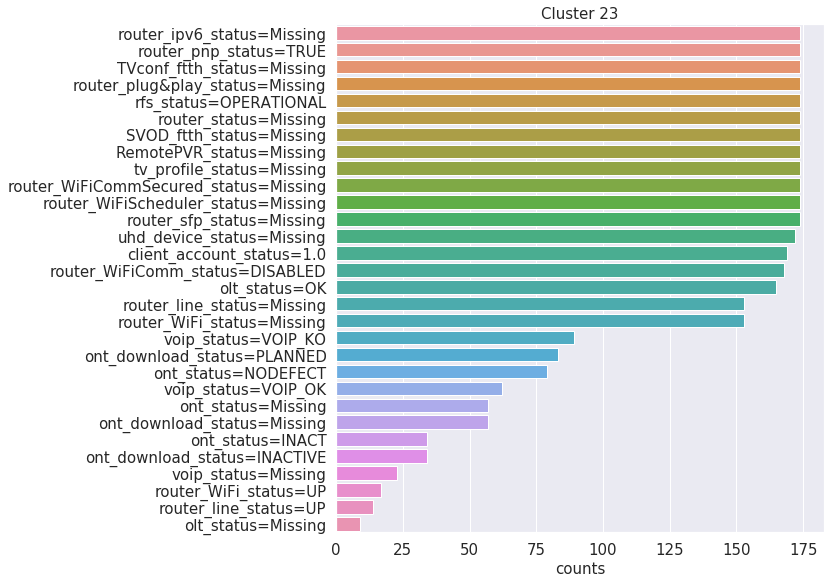

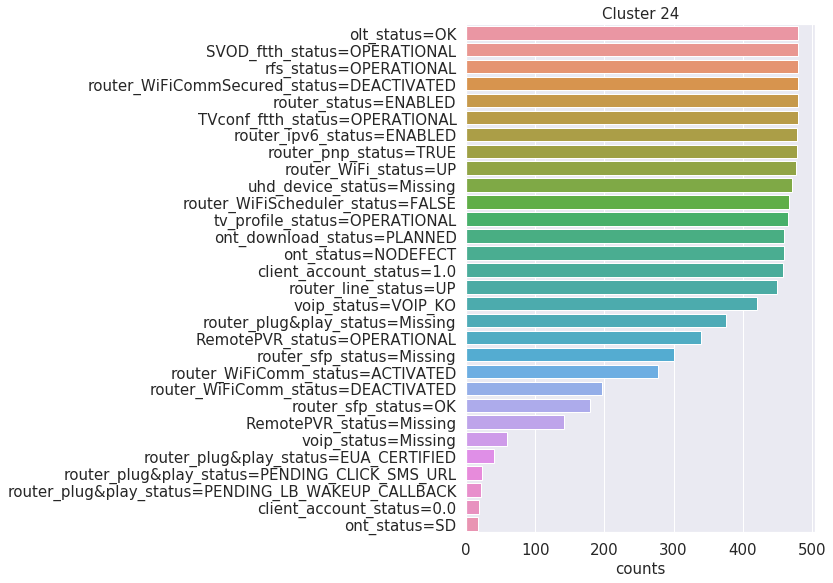

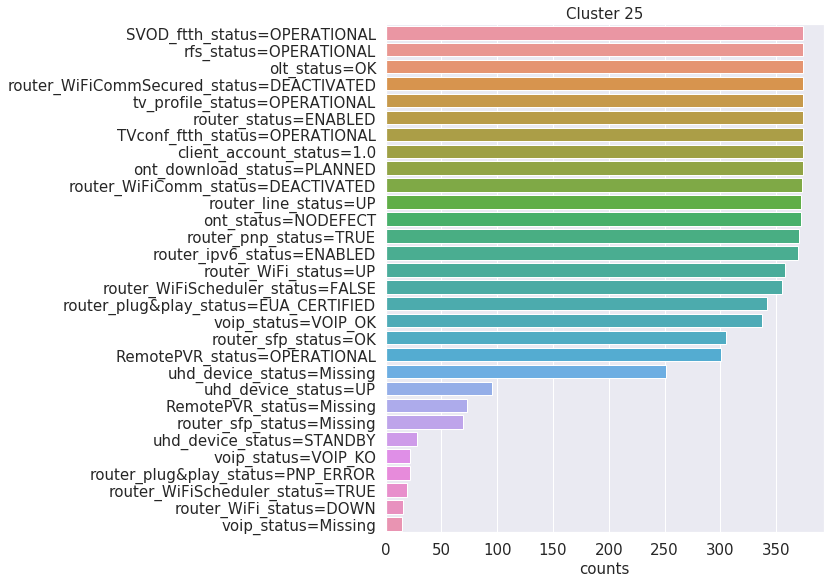

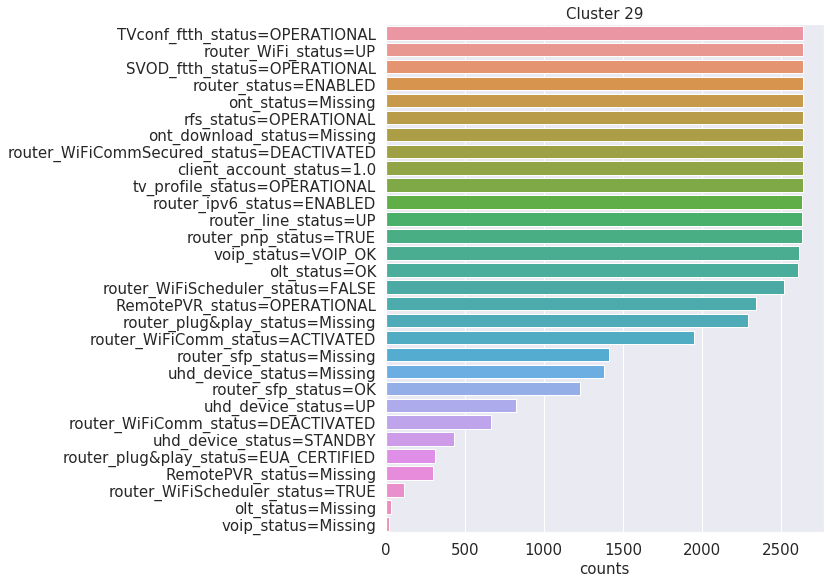

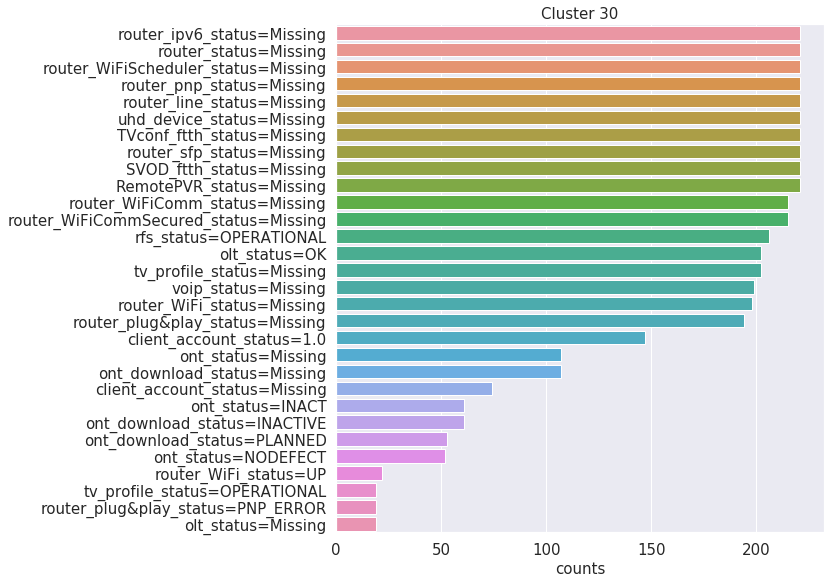

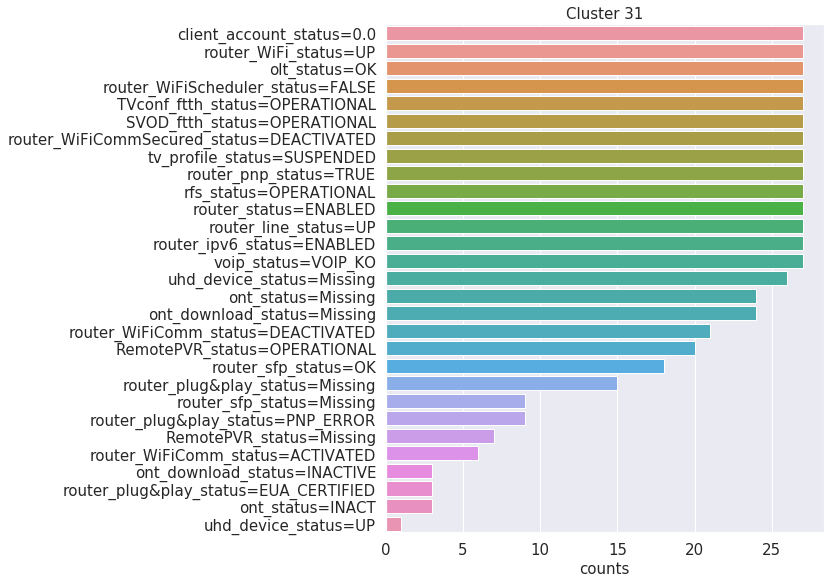

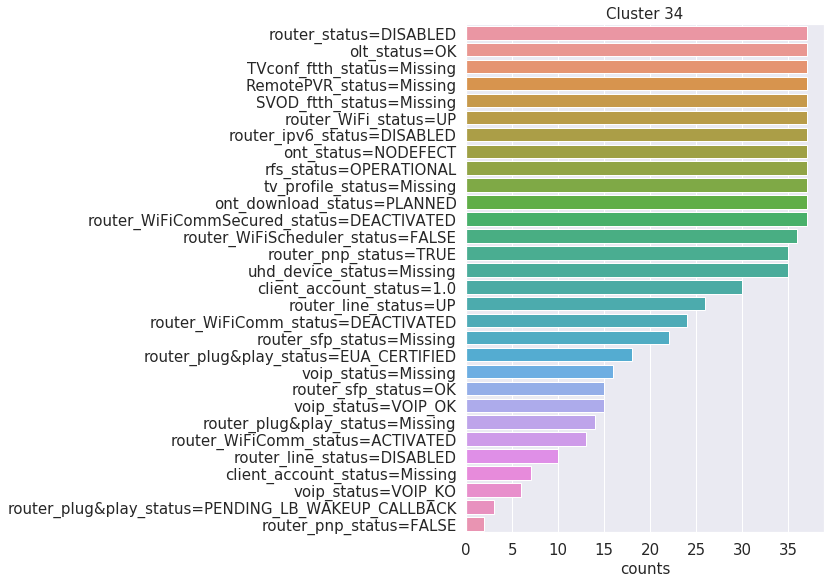

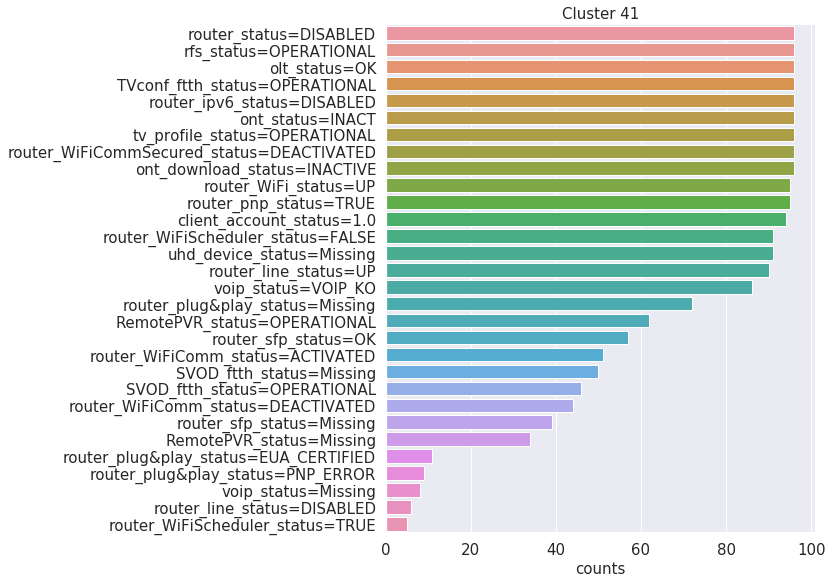

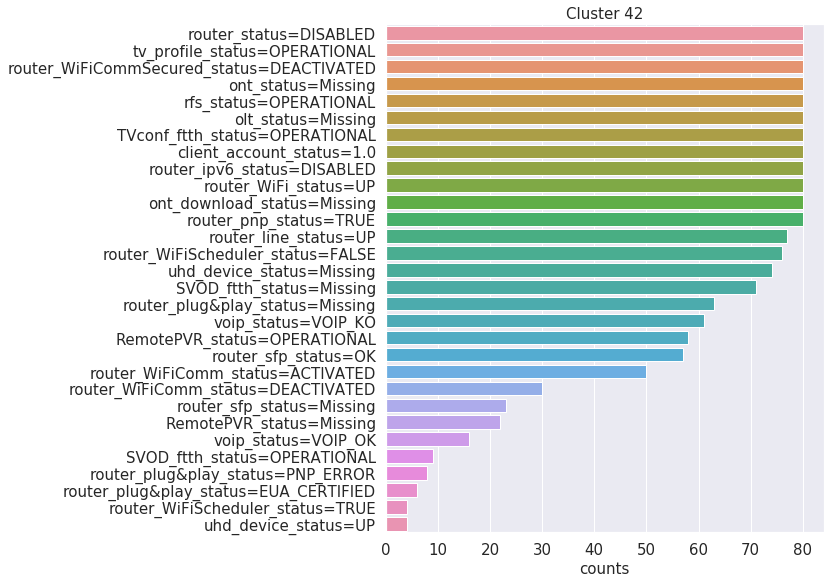

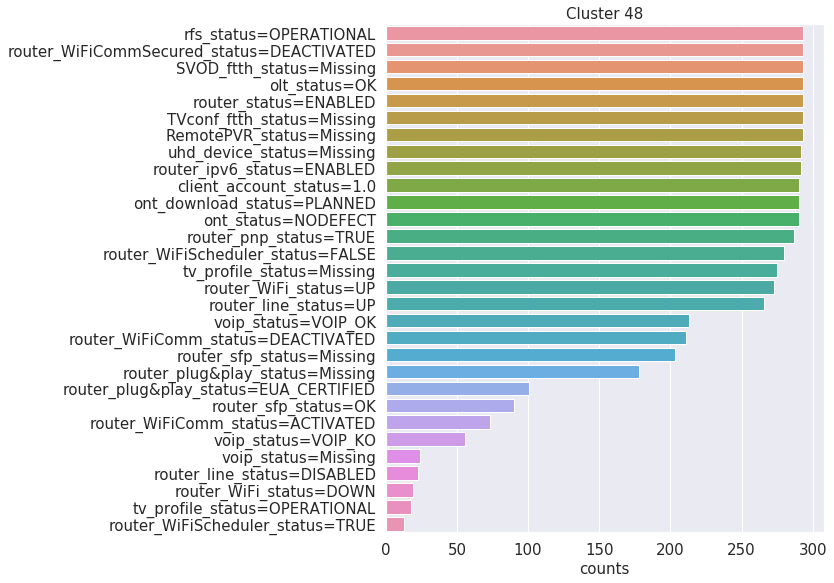

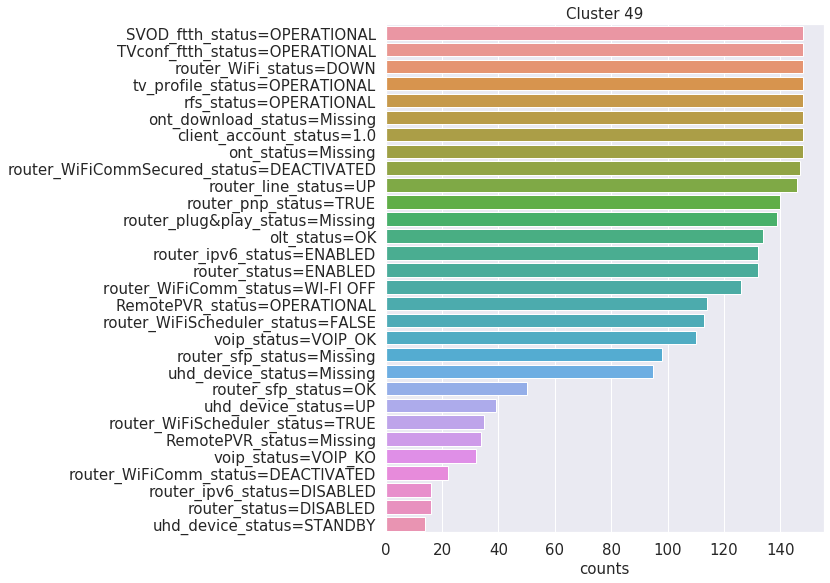

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
from utils import most_accuring_terms
i=0
for cluster_index in np.unique(y_pred):
    inds = np.where(y_pred == cluster_index)[0]
    cluster_data = data.iloc[inds, :]
    accurring_assignments = most_accuring_terms(cluster_data)
    accurring_assignments = accurring_assignments.to_frame()
    accurring_assignments = accurring_assignments.drop("cluster="+str(cluster_index),axis=0)
    index_t = list(accurring_assignments.index)
    vals = list(accurring_assignments[0].values)
    plt.figure(i)
    plot_df = pd.DataFrame({"terms":index_t, "counts":vals}).iloc[:30, :]
    plot_df.to_csv("result_df_cluster"+str(cluster_index), index=None)
    ax = sns.barplot(x="counts", y="terms", data=plot_df)
    plt.title("Cluster "+str(cluster_index + 1), fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("counts", fontsize=15)
    plt.ylabel("", fontsize=15)
    plt.tight_layout()
    plt.savefig("cluster_"+str(i+1)+".pdf")
    i+=1